In [1]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2020-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-06-01"  # Enddatum, bis zu dem Daten überprüft werden sollen

# Daten aus der Tabelle in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date))

# added
data["ID"] = data.index
data = data[["ID", "Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())

      ID       Date Company Type        Open        High         Low  \
730  730 2023-05-25    AAPL  ACT  172.410004  173.899994  171.690002   
731  731 2023-05-26    AAPL  ACT  173.320007  175.770004  173.110001   
732  732 2023-05-30    AAPL  ACT  176.960007  178.990005  176.570007   
733  733 2023-05-31    AAPL  ACT  177.330002  179.350006  176.759995   
734  734 2023-06-01    AAPL  ACT  177.699997  180.119995  176.929993   

          Close    Volume  
730  172.990005  56058300  
731  175.429993  54835000  
732  177.300003  55964400  
733  177.250000  99625300  
734  180.089996  68901800  


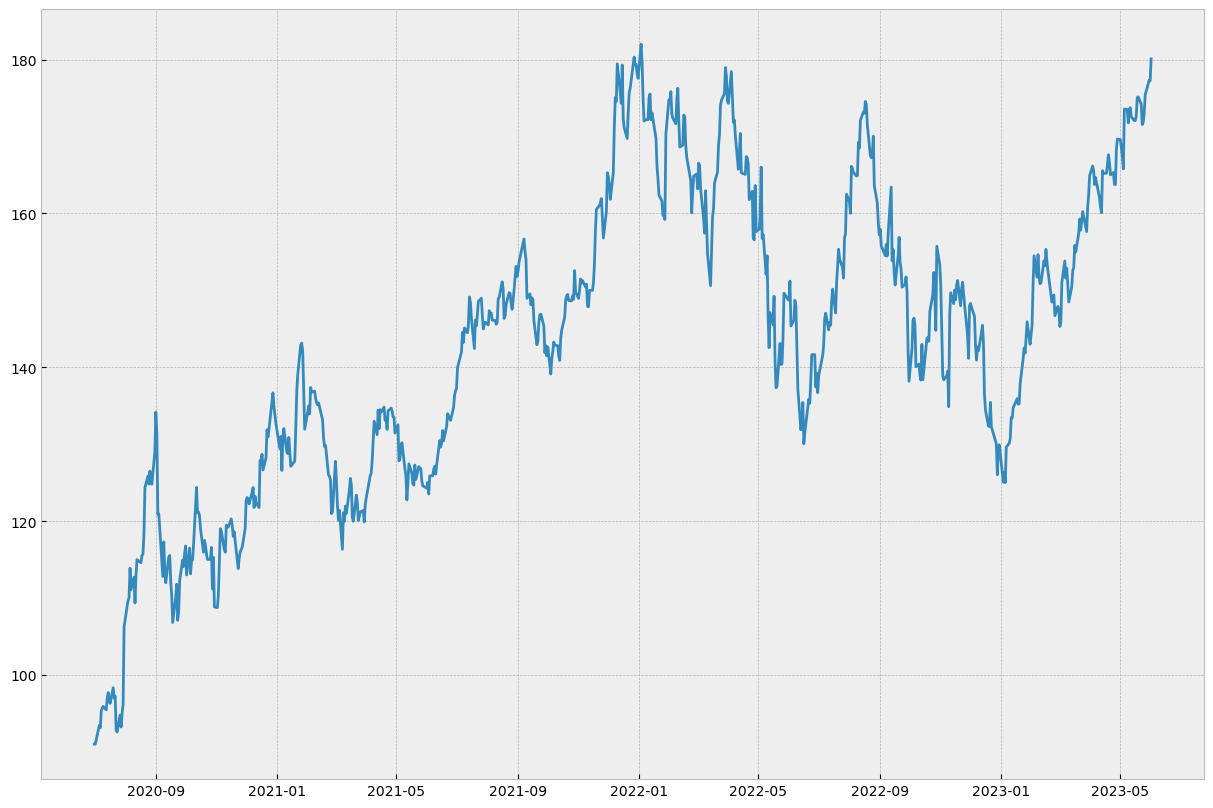

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

In [3]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Download stock data
#stock_data = yf.download('GOOG', start='2016-01-01', end='2023-07-01')

# Extract closing prices
close_prices = data['Close']
values = close_prices.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

# Prepare training data
training_data_len = math.ceil(len(values) * 0.8)
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build and train the model
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

# Prepare test data for predictions
test_data = scaled_data[training_data_len-60:, :]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate predictions for the future
future_periods = 30
x_future = x_test[-1]  # Use the last available sequence as the starting point

future_predictions = []
for _ in range(future_periods):
    x_future = np.reshape(x_future, (1, x_future.shape[0], 1))
    future_prediction = model.predict(x_future)
    future_predictions.append(future_prediction[0, 0])
    x_future = np.append(x_future[0][1:], future_prediction)

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame with predicted prices
future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(days=1), periods=future_periods, freq='D')
predicted_prices = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted Price'])

# Plotting historical data and predicted prices
plt.figure(figsize=(16,8))
plt.title('Historical and Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(data['Close'], label='Historical Data')
plt.plot(predicted_prices, label='Predicted Prices')
plt.legend(loc='upper left')
plt.show()


Epoch 1/3
528/528 [==============================] - 14s 20ms/step - loss: 0.0067
Epoch 2/3
528/528 [==============================] - 11s 21ms/step - loss: 0.0031
Epoch 3/3
1/1 [==============================] - 0s 30ms/step


NameError: name 'stock_data' is not defined

In [ ]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Download stock data
#stock_data = yf.download('GOOG', start='2016-01-01', end='2023-07-01')

# Extract closing prices
close_prices = data['Close']
values = close_prices.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

# Prepare training data
training_data_len = math.ceil(len(values) * 0.8)
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build and train the model
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

# Prepare test data for predictions
test_data = scaled_data[training_data_len-60:, :]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate predictions for the future
future_periods = 30
x_future = x_test[-1]  # Use the last available sequence as the starting point

future_predictions = []
for _ in range(future_periods):
    x_future = np.reshape(x_future, (1, x_future.shape[0], 1))
    future_prediction = model.predict(x_future)
    future_predictions.append(future_prediction[0, 0])
    x_future = np.append(x_future[0][1:], future_prediction)

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame with predicted prices
future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(days=1), periods=future_periods, freq='D')
predicted_prices = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted Price'])

# Plotting historical data and predicted prices
plt.figure(figsize=(16,8))
plt.title('Historical and Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(data['Close'], label='Historical Data')
plt.plot(predicted_prices, label='Predicted Prices')
plt.legend(loc='upper left')
plt.show()


In [ ]:
print(predicted_prices)